# Part 1 - Data Preprocessing

This dataset relates to the Pima Indian Population, near Phoenix, Arizona. The study is fairly old, starting in 1965, with a range of variables being chosen based upon their significance in other studies, including the number of times the individual had been pregnant, body mass index, and age.

First, let's load the data,

In [1]:
import pandas as pd
diabetes = pd.read_csv('../input/pima-indians-diabetes-database//diabetes.csv')

In [2]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


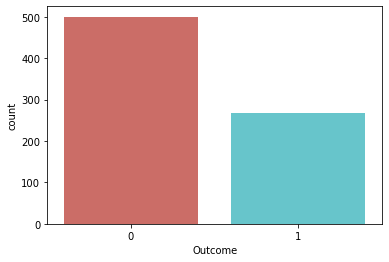

In [3]:
import seaborn as sns
%matplotlib inline

sns.countplot(x='Outcome', data=diabetes, palette='hls')

Mean numbers according to outcome

In [ ]:
diabetes.groupby('Outcome').mean()

From the look of this outcome, if you have 4.86 children, you might be in trouble.

Next, load a few bits and pieces, and then check for any missing values,

In [9]:
import numpy as np
from sklearn import linear_model, datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
diabetes.isnull().sum()

# Part 2 - Data Visualization

Glucose is important! Let's use a box-plot to see the difference in terms of outcome,

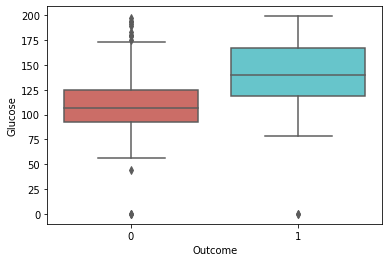

In [5]:
sns.boxplot(x='Outcome', y='Glucose', data=diabetes, palette='hls')

So, glucose is raised, on average, in cases with diabetes. And of course, if we wanted to get into feature selection, the classic correlation plot would be useful,

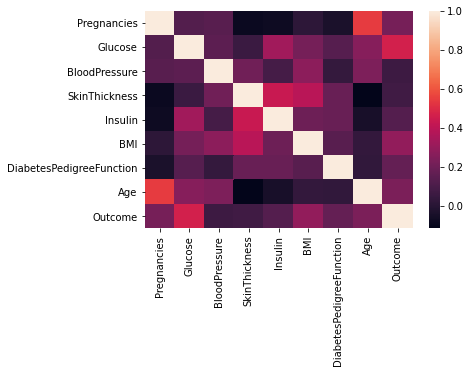

In [6]:
sns.heatmap(diabetes.corr())

# Applying Different Classification Methods

Now, let's create a quick, crude model using logistic regression (including splitting into training and test sets, and making predictions),

In [10]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop('Outcome', 1), diabetes['Outcome'], test_size = .3, random_state=25)

In [11]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
y_pred_quant = LogReg.predict_proba(X_test)[:, 1] #Only keep the first column, which is the 'pos' values
y_pred_bin = LogReg.predict(X_test)

Now let's create a confusion matrix, and work out the sensitivity and specificity,

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[138,  22],
       [ 25,  46]])

In [16]:
from sklearn.metrics import classification_report

total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
print('Specificity : ', specificity)

Sensitivity :  0.8625
Specificity :  0.647887323943662


Now we encounter the first issue in the world of diagnostic testing, which is that sensitivity and specificity are often treated as static, where-as it of course depends upon the threshold you choose for determining what classes as a positive and what classes as a negative. To check the full range, we use a Receiver Operator Curve (ROC),

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_quant)

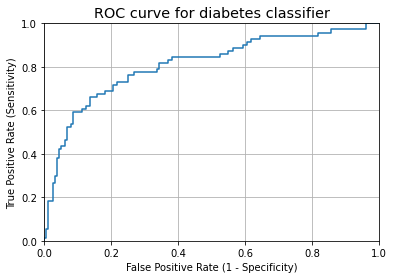

In [18]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

* 0.90 - 1.00 = excellent
* 0.80 - 0.90 = good
* 0.70 - 0.80 = fair
* 0.60 - 0.70 = poor
* 0.50 - 0.60 = fail

Let's see what the above ROC gives us,

In [19]:
metrics.auc(fpr, tpr)

0.8106514084507042

Borderline good!